In [1]:
%pip install python-vlc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
print(sys.version)

3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]


In [3]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/torchvision-0.2.0-py2.py3-none-any.whl (48 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torchaudio (from versions: none)
ERROR: No matching distribution found for torchaudio


In [4]:
%pip install opencv-python
%pip install opencv-python-headless

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
# ===============================
# VIDEO RETRIEVAL SYSTEM (FULL)
# ===============================
import os
from pydub import AudioSegment
import speech_recognition as sr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore", message="FP16 is not supported on CPU")
import whisper
import cv2
from pydub import AudioSegment
from IPython.display import display, Image, clear_output
import time
from IPython.display import Video
from IPython.display import Audio
from matplotlib import pyplot as plt
from IPython.display import clear_output, display, Audio

In [6]:
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

In [7]:

# Set ffmpeg paths manually
AudioSegment.ffmpeg = r"D:\FFMPEG\1\bin\ffmpeg.exe"
AudioSegment.converter = r"D:\FFMPEG\1\bin\ffmpeg.exe"
AudioSegment.ffprobe   = r"D:\FFMPEG\1\bin\ffprobe.exe"

In [8]:
VIDEO_PATH = r"D:\FFMPEG"
TRANSCRIPT_PATH = r"D:\FFMPEG"

os.makedirs(VIDEO_PATH, exist_ok=True)
os.makedirs(TRANSCRIPT_PATH, exist_ok=True)


In [9]:
def video_to_audio(video_file):
    audio_file = os.path.join(TRANSCRIPT_PATH, os.path.basename(video_file).replace(".mp4", ".wav"))
    AudioSegment.from_file(video_file).export(audio_file, format="wav")
    return audio_file

In [10]:
def audio_to_text(audio_file):
    r = sr.Recognizer()
    with sr.AudioFile(audio_file) as source:
        audio_data = r.record(source)
    try:
        text = r.recognize_google(audio_data)
    except sr.UnknownValueError:
        text = ""
    except sr.RequestError as e:
        print(f"Speech recognition error: {e}")
        text = ""
    return text

In [11]:

# -------------------------------
# STEP 1: TRANSCRIBE VIDEOS WITH TIMESTAMPS
# -------------------------------
def generate_transcripts():
    if not os.path.exists(TRANSCRIPT_PATH):
        os.makedirs(TRANSCRIPT_PATH)

    model = whisper.load_model("base")  # can use "small" / "medium" for better accuracy

    for file in os.listdir(VIDEO_PATH):
        if file.endswith(".mp4"):
            video_file = os.path.join(VIDEO_PATH, file)
            print(f"Transcribing: {file} ...")
            result = model.transcribe(video_file)

            transcript_file = os.path.join(TRANSCRIPT_PATH, file.replace(".mp4", ".txt"))
            with open(transcript_file, "w", encoding="utf-8") as f:
                for seg in result["segments"]:
                    start = seg["start"]
                    end = seg["end"]
                    text = seg["text"].strip()
                    f.write(f"{start:.2f}-{end:.2f}  {text}\n")
            print(f"Saved transcript: {transcript_file}")


In [12]:

# -------------------------------
# STEP 2: SEARCH QUERY
# -------------------------------
def search_video(query, vectorizer, vectors, files, timestamps, documents, top_n=5):
    q_vec = vectorizer.transform([query])
    scores = cosine_similarity(q_vec, vectors)[0]

    results = sorted(
        zip(files, timestamps, scores, documents),
        key=lambda x: x[2],
        reverse=True
    )[:top_n]

    print("\nSearch Results:\n")
    for idx, (f, ts, score, text) in enumerate(results, 1):
        print(f"{idx}. {f} | Timestamp: {ts} | Score: {score:.3f}")
        print(f"Text: {text}\n")
    return results


In [13]:

# -------------------------------
# STEP 3: BUILD LINE-LEVEL INDEX
# -------------------------------
def build_index():
    documents = []
    timestamps = []
    files = []

    for file in os.listdir(TRANSCRIPT_PATH):
        if file.endswith(".txt"):
            path = os.path.join(TRANSCRIPT_PATH, file)
            with open(path, "r", encoding="utf-8") as f:
                for line in f:
                    if line.strip() == "":
                        continue
                    try:
                        ts, text = line.split("  ", 1)
                        documents.append(text.strip())
                        timestamps.append(ts.strip())
                        files.append(file.replace(".txt", ".mp4"))
                    except ValueError:
                        continue

    vectorizer = TfidfVectorizer(stop_words="english")
    vectors = vectorizer.fit_transform(documents)
    print("Index built successfully!")
    return vectorizer, vectors, files, timestamps, documents


In [14]:

# -------------------------------
# STEP 4: PLAY VIDEO SEGMENT
# -------------------------------
def play_video_segment(video_file, start_time, end_time):
    cap = cv2.VideoCapture(video_file)

    if not cap.isOpened():
        print("Error opening video file:", video_file)
        return

    fps = cap.get(cv2.CAP_PROP_FPS)
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or cap.get(cv2.CAP_PROP_POS_FRAMES) > end_frame:
            break

        cv2.imshow('Video Segment', frame)
        if cv2.waitKey(int(1000/fps)) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    player = vlc.MediaPlayer(video_file)
    player.play()
    time.sleep(0.5)  # wait for player to start

    # Jump to start time (milliseconds)
    player.set_time(int(start_time * 1000))

    # Play until end_time
    duration = end_time - start_time
    time.sleep(duration)

    player.stop()

# -------------------------------
# STEP 5: MAIN FUNCTION TO RUN SYSTEM
# -------------------------------
def main():
    print("Generating transcripts...")
    generate_transcripts()

    print("\nBuilding index...")
    vectorizer, vectors, files, timestamps, documents = build_index()

    while True:
        query = input("\nEnter your search query (or 'exit' to quit): ")
        if query.lower() == "exit":
            break

        results = search_video(query, vectorizer, vectors, files, timestamps, documents)

        # Play the top result automatically
        if results:
            top_file, top_ts, top_score, top_text = results[0]
            start, end = map(float, top_ts.split("-"))
            print(f"\nPlaying top video segment: {top_file} ({start}-{end} sec)")
            play_video_segment(os.path.join(VIDEO_PATH, top_file), start, end)

# -------------------------------
# RUN
# -------------------------------



In [15]:

def play_video_segment_inline(video_file, start_time, end_time):
    cap = cv2.VideoCapture(video_file)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Calculate start and end frames
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        if current_frame > end_frame:
            break
        
        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        _, buffer = cv2.imencode('.jpg', frame)
        display(Image(data=buffer.tobytes()))
        clear_output(wait=True)
        time.sleep(1/fps)
    
    cap.release()


In [16]:
# Load the audio file
audio = AudioSegment.from_wav(r"D:\FFMPEG\On Semantic Similarity in Video Retrieval.wav")

# Slice 10-15 seconds
start_ms = 10 * 1000  # convert seconds → milliseconds
end_ms = 15 * 1000
segment = audio[start_ms:end_ms]

# Export temporarily to play in Jupyter
segment.export("temp_segment.wav", format="wav")

# Play the sliced audio
Audio("temp_segment.wav", autoplay=True)


In [17]:

def play_media_segment(file_path, start_time, end_time):
    ext = os.path.splitext(file_path)[1].lower()
    
    if ext in ['.mp4', '.avi', '.mov']:
        # Video playback
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            print(f"Error opening video file: {file_path}")
            return
        
        fps = cap.get(cv2.CAP_PROP_FPS)
        start_frame = int(start_time * fps)
        end_frame = int(end_time * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret or cap.get(cv2.CAP_PROP_POS_FRAMES) > end_frame:
                break
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            clear_output(wait=True)
            display(plt.imshow(frame_rgb))
            time.sleep(1/fps)
        
        cap.release()
    
    elif ext in ['.wav', '.mp3']:
        # Audio playback
        audio = AudioSegment.from_file(file_path)
        start_ms = int(start_time * 1000)
        end_ms = int(end_time * 1000)
        segment = audio[start_ms:end_ms]
        segment.export("temp_segment.wav", format="wav")
        display(Audio("temp_segment.wav", autoplay=True))
    
    else:
        print("Unsupported file format:", ext)


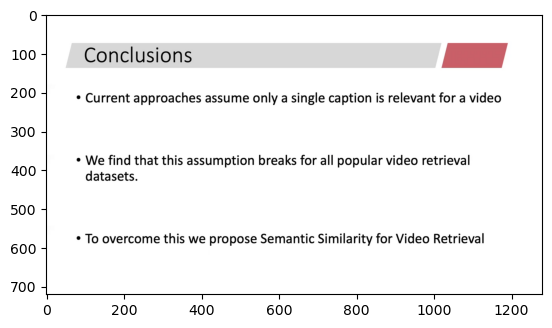

In [23]:
# For video segment
play_media_segment(r"D:\FFMPEG\a.mp4", 243, 251)

# For audio segment
play_media_segment(r"D:\FFMPEG\On Semantic Similarity in Video Retrieval.wav", 10, 15)


In [18]:
if __name__ == "__main__":
    main()

Generating transcripts...
Transcribing: a.mp4 ...
Saved transcript: D:\FFMPEG\a.txt

Building index...
Index built successfully!



Enter your search query (or 'exit' to quit):  exit
